processed cancer: 2000
processed non_cancer: 2000
train cancer: 1600
train non_cancer: 1600
val cancer: 400
val non_cancer: 400


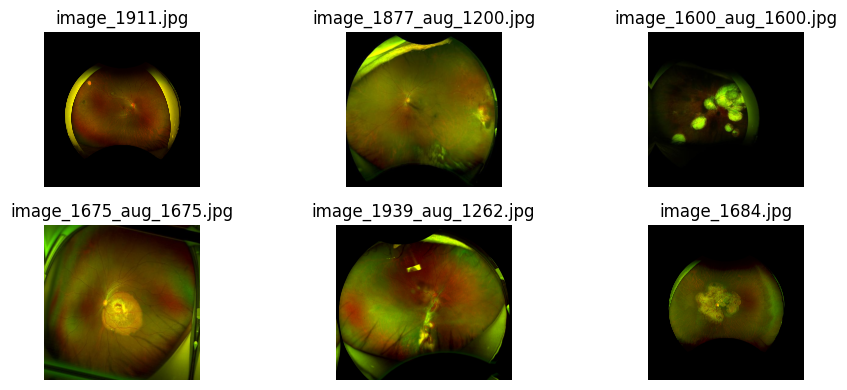

In [2]:
from pathlib import Path
from PIL import Image
import random, matplotlib.pyplot as plt

BASE = Path("C:\\Users\\adith\\Downloads\\EyeCancer\\data")
proc = BASE/"processed"
split = BASE/"split"

def cnt(p): return len(list(p.rglob("*.*")))
print("processed cancer:", cnt(proc/"cancer"))
print("processed non_cancer:", cnt(proc/"non_cancer"))
print("train cancer:", cnt(split/"train"/"cancer"))
print("train non_cancer:", cnt(split/"train"/"non_cancer"))
print("val cancer:", cnt(split/"val"/"cancer"))
print("val non_cancer:", cnt(split/"val"/"non_cancer"))

# show 6 cancer samples (some augmented)
samples = list((proc/"cancer").glob("*.*"))
random.shuffle(samples)
plt.figure(figsize=(10,4))
for i,p in enumerate(samples[:6]):
    img = Image.open(p)
    plt.subplot(2,3,i+1); plt.axis('off'); plt.title(p.name)
    plt.imshow(img)
plt.tight_layout()
plt.show()


In [3]:
import hashlib
from pathlib import Path
TRAIN = Path("C:/data/split/train")
VAL   = Path("C:/data/split/val")

def file_hash(p):
    h = hashlib.sha256()
    with open(p,"rb") as f: h.update(f.read())
    return h.hexdigest()

train_hashes = {file_hash(p):p for p in TRAIN.rglob("*.*")}
val_hashes   = {file_hash(p):p for p in VAL.rglob("*.*")}
dups = set(train_hashes).intersection(val_hashes)
print("Exact duplicate count between train & val:", len(dups))
if len(dups):
    for d in list(dups)[:5]:
        print("dup:", train_hashes[d], val_hashes[d])


Exact duplicate count between train & val: 0


In [4]:
# CELL A
import os, math, random
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# reproducible seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# paths & hyperparams (edit only if needed)
PROJECT_DATA = "C:\\Users\\adith\\Downloads\\EyeCancer\\data"
TRAIN_DIR = os.path.join(PROJECT_DATA, "split", "train")
VAL_DIR   = os.path.join(PROJECT_DATA, "split", "val")
IMG_SIZE = (224, 224)   # model input size
BATCH_SIZE = 16         # reduce to 8/4 if GPU OOM
INITIAL_EPOCHS = 8
FINETUNE_EPOCHS = 20

print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)


TRAIN_DIR: C:\Users\adith\Downloads\EyeCancer\data\split\train
VAL_DIR: C:\Users\adith\Downloads\EyeCancer\data\split\val


In [5]:
# CELL B
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    horizontal_flip=True,
    brightness_range=(0.9,1.1)
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=RANDOM_SEED
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=RANDOM_SEED
)

steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)
validation_steps = math.ceil(val_gen.samples / BATCH_SIZE)
print("samples (train/val):", train_gen.samples, val_gen.samples)
print("steps (train/val):", steps_per_epoch, validation_steps)


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
samples (train/val): 3200 800
steps (train/val): 200 50


batch_x.shape: (16, 224, 224, 3)
batch_y.shape: (16,)


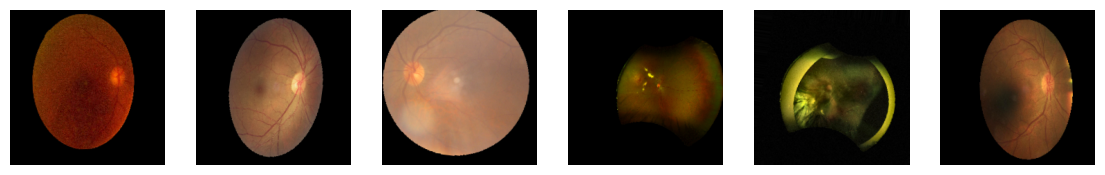

class distribution in batch: [9 7]


In [6]:
# CELL C
batch_x, batch_y = next(iter(train_gen))
print("batch_x.shape:", batch_x.shape)
print("batch_y.shape:", batch_y.shape)
# show first 6 images after preprocess inverse (for visualization)
def show_img(arr, ax):
    # arrays are preprocessed by preprocess_input (centered) - convert for display approx:
    img = arr.copy()
    img = (img - img.min()) / (img.max() - img.min())  # scale 0-1 for display
    ax.imshow(img)
    ax.axis('off')

fig, axs = plt.subplots(1,6, figsize=(14,4))
for i in range(6):
    show_img(batch_x[i], axs[i])
plt.show()
print("class distribution in batch:", np.bincount(batch_y.astype(int)))


In [7]:
# CELL D
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base = EfficientNetV2B3(include_top=False, weights='imagenet', input_tensor=input_tensor)
base.trainable = False   # freeze base for initial training

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 40  1080        ['normalization[0][0]']      

In [8]:
# CELL E
# class weights (optional if perfectly balanced; safe to include)
labels = train_gen.classes
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(cw))
print("class_weights:", class_weights)

# callbacks
ckpt1 = ModelCheckpoint("best_initial.h5", monitor="val_auc", mode="max", save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1)

callbacks = [ckpt1, es, rlr]


class_weights: {0: 1.0, 1: 1.0}


In [9]:
# CELL F
history_init = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=INITIAL_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/8
200/200 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9219 - auc: 0.9697
Epoch 1: val_auc improved from -inf to 0.98738, saving model to best_initial.h5
200/200 [==============================] - 278s 1s/step - loss: 0.1932 - accuracy: 0.9219 - auc: 0.9697 - val_loss: 0.1932 - val_accuracy: 0.9062 - val_auc: 0.9874 - lr: 0.0010
Epoch 2/8
200/200 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9366 - auc: 0.9841
Epoch 2: val_auc improved from 0.98738 to 0.99261, saving model to best_initial.h5
200/200 [==============================] - 204s 1s/step - loss: 0.1443 - accuracy: 0.9366 - auc: 0.9841 - val_loss: 0.1107 - val_accuracy: 0.9600 - val_auc: 0.9926 - lr: 0.0010
Epoch 3/8
200/200 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9356 - auc: 0.9854
Epoch 3: val_auc did not improve from 0.99261
200/200 [==============================] - 225s 1s/step - loss: 0.1382 - accuracy: 0.9356 - auc: 0.9854 - val_

In [10]:
# CELL G
# Unfreeze the whole base (or fine-tune last N layers)
N = 30   # adjust: number of base layers to keep trainable at the end
base.trainable = True
# freeze earlier layers if you want: keep only last N layers trainable
if N is not None:
    for layer in base.layers[:-N]:
        layer.trainable = False

# compile with low LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

ckpt2 = ModelCheckpoint("best_finetuned.h5", monitor="val_auc", mode="max", save_best_only=True, verbose=1)
rlr2 = ReduceLROnPlateau(monitor="val_auc", factor=0.2, patience=3, min_lr=1e-7, mode="max", verbose=1)
es2 = EarlyStopping(monitor="val_auc", patience=6, mode="max", restore_best_weights=True, verbose=1)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=FINETUNE_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[ckpt2, rlr2, es2]
)


Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9544 - auc: 0.9908
Epoch 1: val_auc improved from -inf to 0.99601, saving model to best_finetuned.h5
200/200 [==============================] - 222s 1s/step - loss: 0.1153 - accuracy: 0.9544 - auc: 0.9908 - val_loss: 0.1175 - val_accuracy: 0.9438 - val_auc: 0.9960 - lr: 1.0000e-05
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9488 - auc: 0.9910
Epoch 2: val_auc improved from 0.99601 to 0.99642, saving model to best_finetuned.h5
200/200 [==============================] - 199s 994ms/step - loss: 0.1147 - accuracy: 0.9488 - auc: 0.9910 - val_loss: 0.1018 - val_accuracy: 0.9600 - val_auc: 0.9964 - lr: 1.0000e-05
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9594 - auc: 0.9935
Epoch 3: val_auc did not improve from 0.99642
200/200 [==============================] - 199s 994ms/step - loss: 0.0995 - accuracy: 0.9594

In [11]:
# CELL H
# load best finetuned (or best_initial.h5 if you didn't finetune)
best_model_path = "best_finetuned.h5"
if not Path(best_model_path).exists():
    best_model_path = "best_initial.h5"
print("Using model:", best_model_path)
m = load_model(best_model_path, compile=False)

# Predict
pred_probs = m.predict(val_gen, steps=validation_steps, verbose=1)
y_true = val_gen.classes[:len(pred_probs)]
y_prob = pred_probs.ravel()
y_pred = (y_prob >= 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["non_cancer","cancer"]))
print("ROC AUC:", roc_auc_score(y_true, y_prob))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


Using model: best_finetuned.h5
50/50 [==============================] - 40s 720ms/step
              precision    recall  f1-score   support

  non_cancer       0.99      0.94      0.97       400
      cancer       0.95      0.99      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

ROC AUC: 0.9972125000000001
Confusion matrix:
 [[378  22]
 [  5 395]]
